In [41]:
import torch

# v1 is a dict
v1 = {
    "1": torch.tensor([0.0, 1.0,1.0], requires_grad=True)  # We will overwrite v1["1"][0] with `a` each iteration
}

# Target norm
target = torch.tensor(5.0)

# Trainable parameter a (1-element tensor)
a = torch.nn.Parameter(torch.tensor(0.0))

# Fixed part of the vector
v1_rest = torch.tensor([1.0, 1.0])  # The fixed second and third components

# Fixed vector to cross with
v2 = torch.tensor([2.0, 1.0, 1.0])  # shape: (3,)

# Optimizer
optimizer = torch.optim.SGD([a], lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()

    # Dynamically create v1 with current a
    v1["1"] = torch.cat([a.view(1), v1_rest])  # shape: (3,)

    # Compute cross product
    cross = torch.cross( v1["1"], v2)

    # Compute norm
    norm = torch.norm(cross)

    # Loss function: squared error
    loss = (norm - target) ** 2

    # Backprop and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: a = {a.item():.4f}, norm = {norm.item():.4f}, loss = {loss.item():.6f}")

print(f"\nFinal value of a: {a.item():.4f}")



Epoch 0: a = -0.0614, norm = 2.8284, loss = 4.715729
Epoch 10: a = -0.5555, norm = 3.5563, loss = 2.084364
Epoch 20: a = -0.8840, norm = 4.0402, loss = 0.921294
Epoch 30: a = -1.1024, norm = 4.3619, loss = 0.407214
Epoch 40: a = -1.2475, norm = 4.5757, loss = 0.179990
Epoch 50: a = -1.3441, norm = 4.7179, loss = 0.079556
Epoch 60: a = -1.4082, norm = 4.8125, loss = 0.035164
Epoch 70: a = -1.4509, norm = 4.8753, loss = 0.015543
Epoch 80: a = -1.4793, norm = 4.9171, loss = 0.006870
Epoch 90: a = -1.4981, norm = 4.9449, loss = 0.003036

Final value of a: -1.5096


In [45]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed, RepulsiveSplineFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss
import torch.nn as nn

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

# Reference of target properties
targets = {'total_energy': torch.tensor([-4.0779]),
           'q_final_atomic': torch.tensor([6.5926, 0.7037, 0.7037])}

# Provide information about the orbitals on each atom
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

# Location at which the DFTB parameter set database is located
parameter_db_path = 'mio.h5'

# Training hyperparameters
number_of_epochs = 250
lr = 0.02

device = torch.device('cpu')

# Construct the Geometry and OrbitalInfo objects
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device), units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

print('Geometry:', geometry)
print('OrbitalInfo:', orbs)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
species = species[species != 0].tolist()

# Load all the necessary feed models
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True)
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline)
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)
u_feed = HubbardFeed.from_database(parameter_db_path, species)
r_feed = RepulsiveSplineFeed.from_database(parameter_db_path, species)

# Create the DFTB calculator
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, r_feed, filling_scheme=None)

original_h =  h_feed._on_sites["1"]
original_o =  h_feed._on_sites["8"]

slice_h = torch.tensor([3.9000e-05, 3.9000e-05, 3.9000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64)
slice_o = torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

torch.manual_seed(4)  # Set random seed for reproducibility

# Create 3 individual trainable parameters
h_param = nn.Parameter(-torch.rand(1, dtype=torch.double))      # For H on-site[0]
o_param_a = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[0]
o_param_b = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[1:4]

h_feed._on_sites = {
    "1": torch.zeros(9, requires_grad=True),
    "8": torch.zeros(9, requires_grad=True)
    }   

# Get the 3 specific parameters for optimization
params = [h_param,o_param_a,o_param_b]


# Define optimizer with the parameters
optimizer = torch.optim.SGD(params, lr=lr)

# Training loop
loss_list = []
for epoch in range(number_of_epochs):
    optimizer.zero_grad()

    # Create parameters directly in the on_sites dictionaries
    # For hydrogen (Z=1)
    h_feed._on_sites["1"]= torch.cat([h_param.view(1), slice_h])  # x parameter
    
    # For oxygen (Z=8)
    h_feed._on_sites["8"]= torch.cat([o_param_a.view(1),o_param_b.view(1).repeat(3),slice_o])  # a parameter 

    # Run DFTB calculation
    dftb_calculator(geometry, orbs, grad_mode="direct")
    # Calculate loss
    energy_loss = mse_loss(dftb_calculator.total_energy, targets['total_energy'])
    mulliken_loss = mse_loss(dftb_calculator.q_final_atomic, targets['q_final_atomic'])

    loss = energy_loss + mulliken_loss
    
    # Backward pass
    loss.backward(retain_graph=True)
    
    # Update parameters
    optimizer.step()
    
    # Record loss
    loss_list.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

# Print final parameters

print("Original H on-site parameters:", original_h)
print("Original O on-site parameters:", original_o)

print(f"Final H on-site parameters: {h_feed._on_sites['1']}")
print(f"Final O on-site parameters: {h_feed._on_sites['8']}")

# Plot the loss
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.linewidth"] = 1.5
plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                right='on', zorder=10)
plt.plot(range(number_of_epochs), loss_list)
plt.xlabel("Iteration", fontsize=28)
plt.ylabel("Loss", fontsize=28)
plt.show()

Geometry: Geometry(OH2)
OrbitalInfo: <tbmalt.structures.orbitalinfo.OrbitalInfo object at 0x7fa64b894990>


TypeError: cannot assign 'dict' as child module '_on_sites' (torch.nn.Module or None expected)

In [43]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed, RepulsiveSplineFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss
import torch.nn as nn

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

# Reference of target properties
targets = {'total_energy': torch.tensor([-4.0779]),
           'q_final_atomic': torch.tensor([6.5926, 0.7037, 0.7037])}

# Provide information about the orbitals on each atom
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

# Location at which the DFTB parameter set database is located
parameter_db_path = 'mio.h5'

# Training hyperparameters
number_of_epochs = 250
lr = 0.02

device = torch.device('cpu')

# Construct the Geometry and OrbitalInfo objects
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device), units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

print('Geometry:', geometry)
print('OrbitalInfo:', orbs)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
species = species[species != 0].tolist()

# Load all the necessary feed models
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True)
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline)
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)
u_feed = HubbardFeed.from_database(parameter_db_path, species)
r_feed = RepulsiveSplineFeed.from_database(parameter_db_path, species)

# Create the DFTB calculator
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, r_feed, filling_scheme=None)

original_h = h_feed._on_sites["1"].clone()
original_o = h_feed._on_sites["8"].clone()

slice_h = torch.tensor([3.9000e-05, 3.9000e-05, 3.9000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64)
slice_o = torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

torch.manual_seed(4)  # Set random seed for reproducibility

# Create 3 individual trainable parameters
h_param = nn.Parameter(-torch.rand(1, dtype=torch.double))      # For H on-site[0]
o_param_a = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[0]
o_param_b = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[1:4]

# SOLUTION 1: Modify the existing tensors directly instead of replacing the dictionary
# This preserves the original structure while making specific elements trainable

# Get the 3 specific parameters for optimization
params = [h_param, o_param_a, o_param_b]

# Define optimizer with the parameters
optimizer = torch.optim.SGD(params, lr=lr)

# Training loop
loss_list = []
for epoch in range(number_of_epochs):
    optimizer.zero_grad()

    # SOLUTION: Update the existing tensors in-place rather than replacing the dictionary
    # For hydrogen (Z=1) - update the first element
    h_feed._on_sites["1"][0] = h_param.squeeze()
    
    # For oxygen (Z=8) - update the first element and elements 1-3
    h_feed._on_sites["8"][0] = o_param_a.squeeze()
    h_feed._on_sites["8"][1:4] = o_param_b.squeeze()

    # Run DFTB calculation
    dftb_calculator(geometry, orbs, grad_mode="direct")
    
    # Calculate loss
    energy_loss = mse_loss(dftb_calculator.total_energy, targets['total_energy'])
    mulliken_loss = mse_loss(dftb_calculator.q_final_atomic, targets['q_final_atomic'])

    loss = energy_loss + mulliken_loss
    
    # Backward pass
    loss.backward(retain_graph=True)
    
    # Update parameters
    optimizer.step()
    
    # Record loss
    loss_list.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

# Print final parameters
print("Original H on-site parameters:", original_h)
print("Original O on-site parameters:", original_o)

print(f"Final H on-site parameters: {h_feed._on_sites['1']}")
print(f"Final O on-site parameters: {h_feed._on_sites['8']}")

# Plot the loss
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.linewidth"] = 1.5
plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                right='on', zorder=10)
plt.plot(range(number_of_epochs), loss_list)
plt.xlabel("Iteration", fontsize=28)
plt.ylabel("Loss", fontsize=28)
plt.show()

Geometry: Geometry(OH2)
OrbitalInfo: <tbmalt.structures.orbitalinfo.OrbitalInfo object at 0x7fa66c58c590>


RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

Geometry: Geometry(OH2)
OrbitalInfo: <tbmalt.structures.orbitalinfo.OrbitalInfo object at 0x7fa66c406250>
h_feed type: <class 'tbmalt.physics.dftb.feeds.SkFeed'>
_on_sites type: <class 'torch.nn.modules.container.ParameterDict'>
Original _on_sites keys: ['1', '8']
Successfully replaced _on_sites!
New _on_sites type: <class 'dict'>
New _on_sites keys: ['1', '8']
H tensor requires_grad: True
O tensor requires_grad: True


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Final Loss 5.7864904644313334e-06
Original H on-site parameters: tensor([-2.3860e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       grad_fn=<CloneBackward0>)
Original O on-site parameters: tensor([-0.8788, -0.3321, -0.3321, -0.3321,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], grad_fn=<CloneBackward0>)
Final H on-site parameters: tensor([-2.4033e-01,  3.9000e-05,  3.9000e-05,  3.9000e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       grad_fn=<CatBackward0>)
Final O on-site parameters: tensor([-0.8752, -0.3331, -0.3331, -0.3331,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], grad_fn=<CatBackward0>)


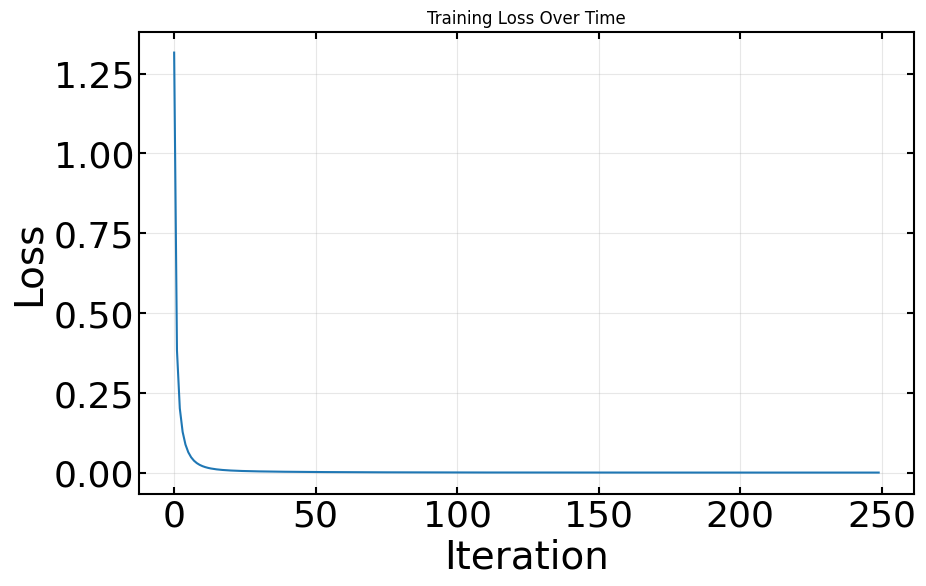

In [59]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed, RepulsiveSplineFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss
import torch.nn as nn

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

# Reference of target properties
targets = {'total_energy': torch.tensor([-4.0779]),
           'q_final_shells': torch.tensor([1.7342, 4.8584, 0.7037, 0.7037])
           }

# Provide information about the orbitals on each atom
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

# Location at which the DFTB parameter set database is located
parameter_db_path = 'mio.h5'

# Training hyperparameters
number_of_epochs = 250
lr = 0.02

device = torch.device('cpu')

# Construct the Geometry and OrbitalInfo objects
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device), units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

print('Geometry:', geometry)
print('OrbitalInfo:', orbs)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
species = species[species != 0].tolist()

# Load all the necessary feed models
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True)
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline)
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)
u_feed = HubbardFeed.from_database(parameter_db_path, species)
r_feed = RepulsiveSplineFeed.from_database(parameter_db_path, species)

# Create the DFTB calculator
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, r_feed, filling_scheme=None)

original_h = h_feed._on_sites["1"].clone()
original_o = h_feed._on_sites["8"].clone()

slice_h = torch.tensor([3.9000e-05, 3.9000e-05, 3.9000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64)
slice_o = torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

torch.manual_seed(4)  # Set random seed for reproducibility

# SOLUTION: Work around the nn.Module restriction by using object.__setattr__
# This bypasses PyTorch's restriction on dictionary assignment

# First, let's see what type of object h_feed is and what _on_sites contains
print("h_feed type:", type(h_feed))
print("_on_sites type:", type(h_feed._on_sites))
print("Original _on_sites keys:", list(h_feed._on_sites.keys()))

# Method 1: Use object.__setattr__ to bypass PyTorch's restrictions
new_on_sites = {
    "1": torch.zeros(9, requires_grad=True, dtype=torch.float64),
    "8": torch.zeros(9, requires_grad=True, dtype=torch.float64)
}

# This bypasses the nn.Module.__setattr__ method that was causing the error
object.__setattr__(h_feed, '_on_sites', new_on_sites)

print("Successfully replaced _on_sites!")
print("New _on_sites type:", type(h_feed._on_sites))
print("New _on_sites keys:", list(h_feed._on_sites.keys()))
print("H tensor requires_grad:", h_feed._on_sites["1"].requires_grad)
print("O tensor requires_grad:", h_feed._on_sites["8"].requires_grad)

# Create 3 individual trainable parameters
h_param = nn.Parameter(-torch.rand(1, dtype=torch.double))      # For H on-site[0]
o_param_a = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[0]
o_param_b = nn.Parameter(-torch.rand(1, dtype=torch.double))    # For O on-site[1:4]

# Get the 3 specific parameters for optimization
params = [h_param, o_param_a, o_param_b]

# Define optimizer with the parameters
optimizer = torch.optim.SGD(params, lr=lr)

# Training loop
loss_list = []
for epoch in range(number_of_epochs):
    optimizer.zero_grad()

    # Now we can update the tensors as you originally intended
    # For hydrogen (Z=1)
    h_feed._on_sites["1"] = torch.cat([h_param.view(1), slice_h])
    
    # For oxygen (Z=8)
    h_feed._on_sites["8"] = torch.cat([o_param_a.view(1), o_param_b.view(1).repeat(3), slice_o])

    # Run DFTB calculation
    dftb_calculator(geometry, orbs, grad_mode="direct")
    
    # Calculate loss
    energy_loss = mse_loss(dftb_calculator.total_energy, targets['total_energy'])
    mulliken_loss = mse_loss(dftb_calculator.q_final_shells, targets['q_final_shells'])
    
    loss = energy_loss + mulliken_loss
    
    # Backward pass
    loss.backward(retain_graph=True)
    
    # Update parameters
    optimizer.step()
    
    # Record loss
    loss_list.append(loss.item())
    

# Print final parameters
print("="*50)
print("Final Loss", loss_list[-1])
print("Original H on-site parameters:", original_h)
print("Original O on-site parameters:", original_o)

print(f"Final H on-site parameters: {h_feed._on_sites['1']}")
print(f"Final O on-site parameters: {h_feed._on_sites['8']}")


# Plot the loss
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.linewidth"] = 1.5
plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                right='on', zorder=10)
plt.plot(range(number_of_epochs), loss_list)
plt.xlabel("Iteration", fontsize=28)
plt.ylabel("Loss", fontsize=28)
plt.title("Training Loss Over Time")
plt.grid(True, alpha=0.3)
plt.show()

